In [64]:
import lmfit as lm
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from edo_model_yang import C0, A0, R_m
from lmfit import Parameters, Minimizer
from edo_model_yang import system_odes, solve_model, solve_fit, plot_fit
from get_data import get_weather_data, get_dengue_data, plot_data, get_temp
from parameters import d, theta_m, mu_a, mu_m, gamma_m, C_yang, sup_cap_sin, sup_cap_yang

Neste notebook é realizado o fitting do modelo considerados três situações diferentes:

- Fitando b, beta e c (valor q será multiplicado por 10^4 e irá representar a capacidade suporte) para o modelo com parâmetros ontomológicos constantes. 

- Fitando b, beta e c (valor q será multiplicado por 10^4 e irá representar a capacidade suporte) para o modelo com parâmetros ontomológicos variando pela temperatura. 

- Fitando b e beta para o modelo com parâmetros ontomológicos variando pela temperatura e a capacidade suporte definida pela fórmula do Yang 2016, que varia com os dados de precipitação. 

No texto acima: 
- b: average bite per mosquito per day. 
- beta: Vai representar beta_m e beta_h, que são as taxas de contato efetivas e por hipótese serão consideradas iguas. 


In [65]:
# parâmetros que serão fixados: 
# parâmetros fixos 
MU_H = 1/(365*67)    #human mortality rate - day^-1
ALPHA_H = 0.1 #recovering rate - day^-1
THETA_H = 0.027   #intrinsic incubation rate - day^-1
K = 0.5          #fraction of female mosquitoes hatched from all egs
C_A = 0.0      #control effort rate on aquatic phase
C_M = 0.0    #control effort rate on terretrial phase

# população de Foz (censo 2010)
N = 256088

par_fixed = MU_H, THETA_H, ALPHA_H, K, C_A, C_M

Capturando os dados de dengue:

In [66]:
df = get_dengue_data()
df.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-07,1.571429,0.857143,0.285714,1.571429
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000


In [67]:
df_2010 = df.loc[(df.index >= '2010-01-08')  &  (df.index <= '2010-07-30')]

df_2010.head()

,notified,probable,lab_confirmed,acum_notified
date,,,,
2010-01-08,1.857143,1.000000,0.142857,3.428571
2010-01-09,1.857143,1.000000,0.142857,5.285714
2010-01-10,2.000000,1.142857,0.142857,7.285714
2010-01-11,1.714286,0.857143,0.142857,9.000000
2010-01-12,2.428571,1.285714,0.571429,11.428571


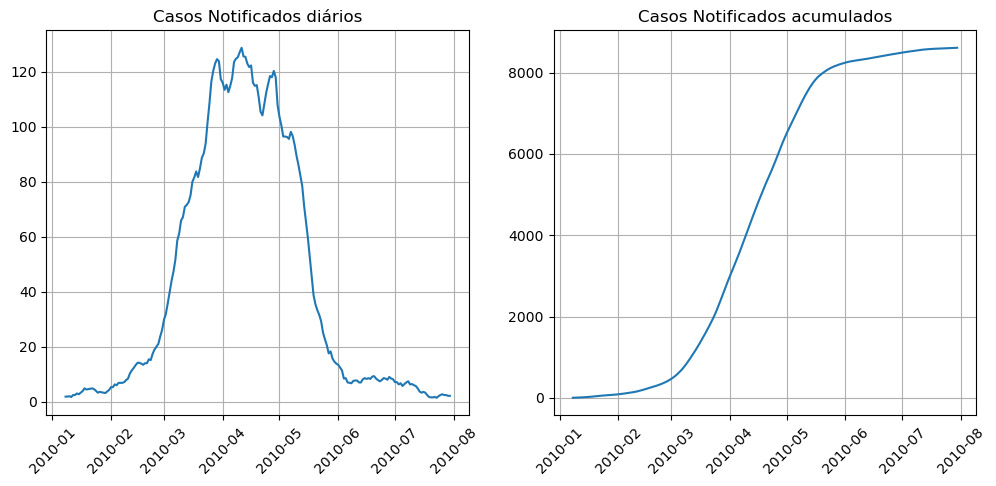

In [68]:
plot_data(df_2010)

In [69]:
df_2010.acum_notified.shape

(204,)

In [70]:
weights = np.ones(df_2010.acum_notified.shape, dtype = float)

for i in np.arange(150, len(weights)):

    weights[i] = 1000
    
weights

array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,

Fitting com os parâmetros fixos:

In [71]:
def fun_obj_fix(params,t, data, par_fixed, C0, A0, Mi0, Hi0, N = 256088, weights = None): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """


    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()
    
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    parametros = b, beta
    
    d_ = lambda t: 5.6
    
    gamma_m_ = lambda t: 0.095
    
    mu_a_ = lambda t: 0.24
    
    mu_m_ = lambda t: 0.055
    
    theta_m_ = lambda t: 0.11
    
    C_ = lambda t: C0
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    phi = pars['phi']
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]

    # Aqui é solucionado o sistema 
    r = solve_model(t, y0, parametros, param_ento, par_fixed)
    
    Hi = r.y[6]
    Hr = r.y[7] - Hr0

    model = Hi + Hr 

    res = (model) - data
    
    res = res*weights
    
    return res  

Parâmetros: 

In [72]:
# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()

params.add('phi', value = 0.4, min = 0.1, max = 1, vary = True) # porcentangem de indivíduos susceptíveis
params.add('b', min = 0.001, max = 1, vary = True)
params.add('beta', min = 0.001, max = 1, vary = True)

data = df_2010.acum_notified

dias = np.arange(0, len(data), 1)

In [73]:
T = get_temp(start_date = '2010-01-08', end_date = '2010-07-30')

print(T[0])

28.0


In [74]:

Ms_0 = N

# para T = 28
k = 0.5
delta__ = 8.39
gamma_m__ = 0.12
mu_a__ = 0.06848
mu_m__ = 0.03039
c_m__ = 0.0

A_0 = A0(Ms_0, gamma_m__, mu_m__, c_m__)

C_0 = C0(Ms_0,k,delta__,gamma_m__, mu_m__,mu_a__, c_m = 0, c_a = 0)

Hi0 = 15
Mi0 = 0

print("A0:", A_0)
print("C0:", C_0)

A0: 64854.28600000001
C0: 65600.71992125978


Aplicando o fitting:

In [75]:
%%time

out = lm.minimize(fun_obj_fix, params, args = (dias, data, par_fixed, C_0, A_0, Mi0, Hi0, N, weights), method = 'leastq')
lm.report_fit(out)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 699
    # data points      = 204
    # variables        = 3
    chi-square         = 6.3838e+14
    reduced chi-square = 3.1760e+12
    Akaike info crit   = 5875.45301
    Bayesian info crit = 5885.40737
[[Variables]]
    phi:   1.00000000 +/- 1.4318e-06 (0.00%) (init = 0.4)
    b:     0.89675487 +/- 0.02014245 (2.25%) (init = 0.001)
    beta:  0.35471575 +/- 0.00807690 (2.28%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, beta) = -0.985
CPU times: user 16.1 s, sys: 29 ms, total: 16.1 s
Wall time: 16.1 s


Plotando a saída do modelo fitado:

In [76]:
def solve_fit(out, t, par_fixed, C0, A0, Mi0, Hi0, N = 256088): 
    '''
    Retorna a saída do modelo com os parâmetros fitados. 

    :params out: saída do lmfit. 
    :params t: array. Intervalo de tempo que deverá ser computado. 
    :params y0: list or array. Deve conter os valores das condições iniciais do modelo. 
    :params temp: array. Array com os valores de temperatura. O tamanho desse array deve ser 
                        condizente com o intervalo de tempo que o modelo será integrado. 
    :params df_we: pd.Dataframe or None. No caso de um dataframe será computado as capacidade
                    suporte usando a fórmula do Yang. 
    :params fixed: boolean. Se True serão usados os parâmetros ontomológicos fixos. 
    '''
    pars = out.params
    pars = pars.valuesdict()
    
    phi = pars['phi']
  
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    par_fit = b, beta
    
    d_ = lambda t: 5.6
    
    gamma_m_ = lambda t: 0.095
    
    mu_a_ = lambda t: 0.24
    
    mu_m_ = lambda t: 0.055
    
    theta_m_ = lambda t: 0.11
    
    C_ = lambda t: C0
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fit = solve_model(t, y0, par_fit, param_ento, par_fixed)

    return r_fit.y[6] + (r_fit.y[7] - Hr0)

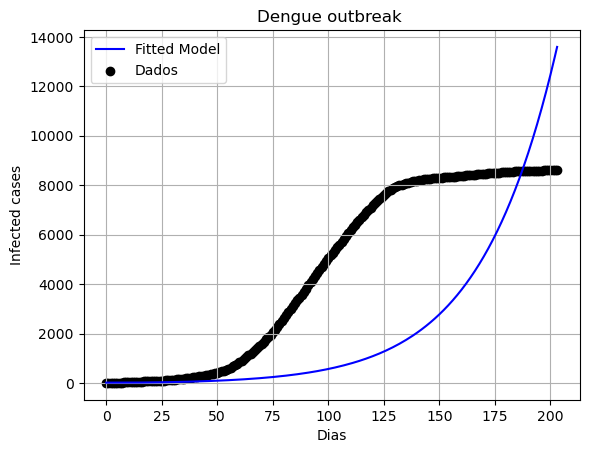

In [77]:

H_fit = solve_fit(out, dias, par_fixed, C_0, A_0, Mi0, Hi0, N = 256088)

plot_fit(dias, data, H_fit)

Fitting com os parâmetros ontomológicos variando no tempo:

In [78]:
def fun_obj_var_onto(params,t, data, par_fixed, T, C0, A0, Mi0, Hi0, N = 256088): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """

    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()
    
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    parametros = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)

    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = lambda t: C0
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    phi = pars['phi']
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]

    # Aqui é solucionado o sistema 
    r = solve_model(t, y0, parametros, param_ento, par_fixed)
    
    Hi = r.y[6]
    Hr = r.y[7] - Hr0

    model = Hi + Hr 

    res = (model) - data
    
    return res  

In [79]:
%%time

out = lm.minimize(fun_obj_var_onto, params, args = (dias, data, par_fixed, T, C_0, A_0, Mi0, Hi0), method = 'leastq')

lm.report_fit(out)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 344
    # data points      = 204
    # variables        = 3
    chi-square         = 1.8628e+09
    reduced chi-square = 9267650.60
    Akaike info crit   = 3275.55398
    Bayesian info crit = 3285.50834
[[Variables]]
    phi:   0.81669641 +/- 1.2237e-04 (0.01%) (init = 0.4)
    b:     0.85104775 +/- 1.3682e-04 (0.02%) (init = 0.001)
    beta:  0.33759582 +/- 1.3953e-04 (0.04%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, b)    = 0.604
    C(b, beta)   = -0.496
    C(phi, beta) = -0.396
CPU times: user 1min 33s, sys: 124 ms, total: 1min 33s
Wall time: 1min 33s


In [80]:
def solve_fit(out, t, par_fixed, T, C0,A0, Mi0, Hi0, N = 256088): 
    '''
    Retorna a saída do modelo com os parâmetros fitados. 

    :params out: saída do lmfit. 
    :params t: array. Intervalo de tempo que deverá ser computado. 
    :params y0: list or array. Deve conter os valores das condições iniciais do modelo. 
    :params temp: array. Array com os valores de temperatura. O tamanho desse array deve ser 
                        condizente com o intervalo de tempo que o modelo será integrado. 
    :params df_we: pd.Dataframe or None. No caso de um dataframe será computado as capacidade
                    suporte usando a fórmula do Yang. 
    :params fixed: boolean. Se True serão usados os parâmetros ontomológicos fixos. 
    '''
    pars = out.params
    pars = pars.valuesdict()
    
    phi = pars['phi']
  
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = lambda t: C0
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fit = solve_model(t, y0, par_fit, param_ento, par_fixed)

    return r_fit.y[6] + (r_fit.y[7] - Hr0)

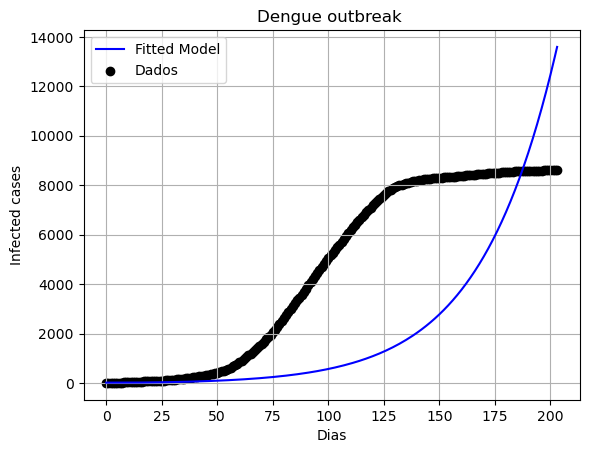

In [81]:
H_fit_onto = solve_fit(out, dias, par_fixed, T, C_0, A_0, Mi0, Hi0, N = 256088)

plot_fit(dias, data, H_fit)

Fitting do modelo fixando a capacidade suporte do yang: 

In [82]:
df_we = get_weather_data()

df_t = df_we.loc[(df_we.index >= '2010-01-01') & (df_we.index <= '2010-07-30')].copy()

df_t.head()

,daily_precipitation-mm,temp_max-celsius,temp_min-celsius,temp_mean-celsius,mean_relative_humidity-%,mean_wind_speed-m_per_s
date,,,,,,
2010-01-01,0.0,31.1,23.9,26.7,72.1,1.7
2010-01-02,2.2,32.9,23.8,27.2,75.3,1.3
2010-01-03,0.0,32.3,25.6,28.4,73.2,1.7
2010-01-04,1.6,33.9,24.6,28.5,75.5,2.5
2010-01-05,0.2,35.2,25.5,29.5,69.1,2.6


In [83]:
def fun_obj_var_onto_cap(params,t, data, par_fixed, T, df_we, A0, Mi0, Hi0, N = 256088): 

    """
    Função objetivo utilizada para o fitting

    ----------
    params : Parametros definidos de acordo com o lmfit 
        Os parâmetros que serão fitados 
    t : list, np.array
        lista com os valores temporais, [0, 1, 2, 3, 4, ..., n] 
    data : np.array
        Array com os dados
    r0: list
      Lista com as condições iniciais para analisar o modelo 
    Returns
    -------
    pd.DataFrame
        Dataframe with the lagged values computed.
    """


    # Aqui serão definidos os parâmetros que serão fitados 
    pars = params.valuesdict()
    
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    parametros = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)

    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = 5, C1=30,C2 = 0.1)
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    phi = pars['phi']
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]

    # Aqui é solucionado o sistema 
    
    try:
        r = solve_model(t, y0, parametros, param_ento, par_fixed)

        Hi = r.y[6]
        Hr = r.y[7] - Hr0

        model = Hi + Hr 

        res = (model) - data
    
    except:
        
        print('Deu merda')
        print(pars)
        
        
        res = data

    return res  

def solve_fit(out, t, par_fixed, T, df_we, A0, Mi0, Hi0, N = 256088): 
    '''
    Retorna a saída do modelo com os parâmetros fitados. 

    :params out: saída do lmfit. 
    :params t: array. Intervalo de tempo que deverá ser computado. 
    :params y0: list or array. Deve conter os valores das condições iniciais do modelo. 
    :params temp: array. Array com os valores de temperatura. O tamanho desse array deve ser 
                        condizente com o intervalo de tempo que o modelo será integrado. 
    :params df_we: pd.Dataframe or None. No caso de um dataframe será computado as capacidade
                    suporte usando a fórmula do Yang. 
    :params fixed: boolean. Se True serão usados os parâmetros ontomológicos fixos. 
    '''
    pars = out.params
    pars = pars.valuesdict()
    
    phi = pars['phi']
  
    b = lambda t:  pars['b']
    
    beta = lambda t: pars['beta']
  
    par_fit = b, beta
    
    d_ = d(T)
    
    gamma_m_ = gamma_m(T)
    
    mu_a_ = mu_a(T)
    
    mu_m_ = mu_m(T)
    
    theta_m_ = theta_m(T)
    
    C_ = C_yang(df_we, k=7,w1=0.5, C0 = 5, C1=30,C2 = 0.1)
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    # definição das condições iniciais
    Ms0 = N
    
    Me0 = 0
    
    Hs0 = phi*N
    
    He0 = 0
    
    Hr0 = (1-phi)*N
    
    y0 = [A0, Ms0, Me0, Mi0, Hs0, He0, Hi0, Hr0]
    
    param_ento = d_, gamma_m_, mu_a_, mu_m_, theta_m_, C_
    
    r_fit = solve_model(t, y0, par_fit, param_ento, par_fixed)

    return r_fit.y[6] + (r_fit.y[7] - Hr0)

In [84]:
%%time

# definição dos parâmetros que serão fitados e os seus intervalos 
params = Parameters()


params.add('phi', value = 0.4, min = 0.1, max = 1, vary = True) # porcentangem de indivíduos susceptíveis
params.add('b', value = 0.5, min = 0.3, max = 0.9, vary = True)
params.add('beta',value = 0.7,  min = 0.3, max = 0.9, vary = True)
params.add('C0', value = 5, min = 4, max = 8, vary = True)
params.add('C2', value = 0.1, min = 0.09, max = 0.5, vary = True)

out = lm.minimize(fun_obj_var_onto_cap, params, args = (dias, data, par_fixed, T, df_t, A_0, Mi0, Hi0), method = 'leastq')

lm.report_fit(out)



[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 578
    # data points      = 204
    # variables        = 5
    chi-square         = 6.2936e+08
    reduced chi-square = 3162608.33
    Akaike info crit   = 3058.18687
    Bayesian info crit = 3074.77747
##  Warning: uncertainties could not be estimated:
[[Variables]]
    phi:   0.99917686 (init = 0.4)
    b:     0.49008022 (init = 0.5)
    beta:  0.88947339 (init = 0.7)
    C0:    5.52223645 (init = 5)
    C2:    0.09642714 (init = 0.1)
CPU times: user 29min 2s, sys: 4.38 s, total: 29min 6s
Wall time: 29min 9s


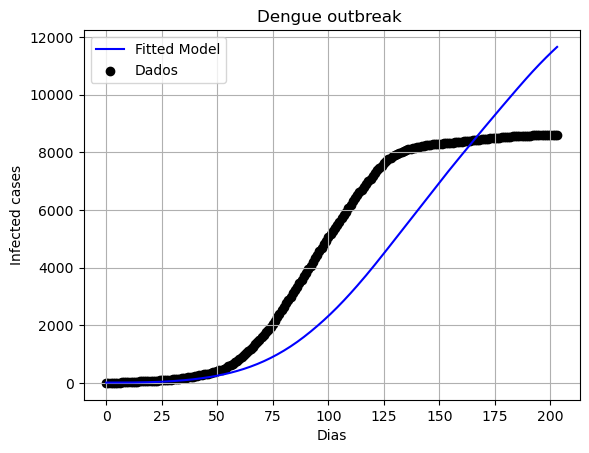

In [91]:
H_fit_onto_cap = solve_fit(out, dias, par_fixed, T, df_t, A_0, Mi0, Hi0, N = 256088)

plot_fit(dias, data, H_fit_onto_cap)

Comparando as estratégias de fitting:

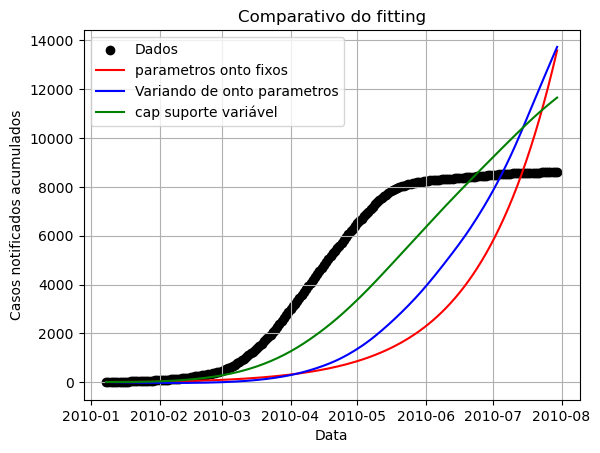

In [92]:
fig, ax = plt.subplots()
 
ax.scatter(data.index, data.values,color='black',label='Dados')

ax.plot(data.index, H_fit, color='red',label='parametros onto fixos')

ax.plot(data.index, H_fit_onto, color='blue',label='Variando de onto parametros')

ax.plot(data.index, H_fit_onto_cap, color='green',label='cap suporte variável')
    
#Set the labels
ax.set_ylabel('Casos notificados acumulados')
ax.set_xlabel('Data')

#Create a grid for visualization
ax.grid()

#Set the title
ax.set_title('Comparativo do fitting')
#The size of the numbers on the axixis

plt.legend()
plt.show()

In [95]:
df = pd.DataFrame()

df['target'] = data

df['pred_fix'] = H_fit

df['pred_onto'] = H_fit_onto

df['pred_cap'] = H_fit_onto_cap

df

,target,pred_fix,pred_onto,pred_cap
date,,,,
2010-01-08,3.428571,15.000000,15.000000,15.000000
2010-01-09,5.285714,14.999561,13.080030,14.991113
2010-01-10,7.285714,15.001360,11.161720,14.986625
2010-01-11,9.000000,15.010321,9.248445,14.995815
2010-01-12,11.428571,15.033266,7.344961,15.031578
...,...,...,...,...
2010-07-26,8598.857143,12107.927730,12882.612520,11363.029850
2010-07-27,8601.285714,12463.824891,13095.652417,11438.137587
2010-07-28,8603.714286,12829.419585,13308.012322,11512.122056


In [98]:
df.to_csv('testing_fit.csv')

<AxesSubplot: xlabel='date'>

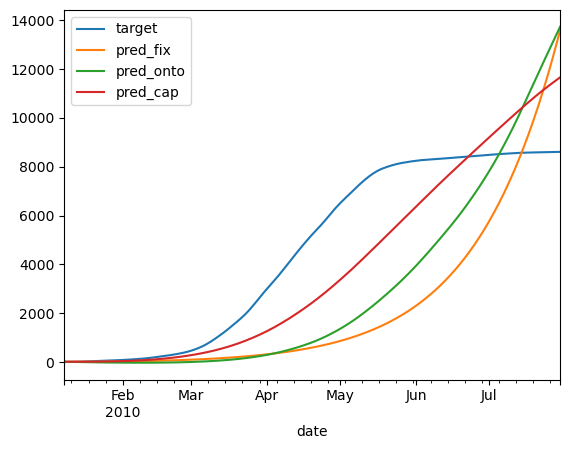

In [97]:
df.plot()